***

### **Readmission Prediction **

**Objective**
Develop a machine learning model to predict patients likely to be readmitted within 30 days (`<30`), enabling the hospital to intervene early and avoid CMS penalties.

**1. Data Strategy & Integrity**
* **Leakage Prevention:** Implemented `GroupShuffleSplit` on `patient_nbr`. This ensures a patient's future visits never leak into the training set, preventing the "time-travel" error common in medical datasets.
* **Cohort Selection:** Removed discharge records related to "Hospice" or "Expired" (Death), as readmission prediction is irrelevant for these cases.
* **Handling Missing Data:** Treated "missing" as a deliberate category (e.g., for `payer_code` or `medical_specialty`) rather than imputing, preserving valuable signal about administrative gaps.

**2. Target Definition Strategy**
We defined the prediction target using a binary approach:
* Binary: `<30` (Urgent) vs. `All Others` (Stable).
    * *Result:* **Selected Strategy.** This isolated the minority class (11% prevalence) and focused the model on the specific problem of immediate readmission penalties.

**3. Feature Engineering Breakthrough**
* **"Visit Count" Feature:** We engineered a historical feature tracking a patient’s cumulative visits (`visit_count`).
* **Impact:** Feature Importance analysis confirmed this is consistently a **Top-3 predictor**, proving that a patient's history of instability is just as important as their current lab results.

**4. Modeling Results**
We progressed through three levels of model complexity to find the "ceiling" of the data:
* **Baseline (Logistic Regression):** Plateaued at **0.66 AUC**. Established that linear relationships alone were insufficient.
* **Intermediate (Random Forest):** Stuck at **0.66 AUC**. Failed to outperform the linear model, suggesting the signal is highly complex.
* **Champion (XGBoost):** Broke the ceiling with **0.672 AUC** (before tuning). Gradient boosting successfully captured complex, non-linear interactions.

**5. Final Optimization (Completed)**
* **Action:** Performed 5-Fold Grid Search Cross-Validation to tune XGBoost hyperparameters.
* **Result:** Achieved a **Final AUC of 0.675**.
* **Key Insight:** The model selected `max_depth=3` (shallow trees) and `min_child_weight=5` (conservative leaf creation). This confirms that the best predictive power comes from broader, simpler rules rather than complex, deep trees which tend to overfit this noisy dataset.


***


## Environment Configuration

We loaded the main Python modules and prepared the analysis environment. It includes visualization libraries such as Matplotlib and Seaborn, interpretation tools like SHAP, and preprocessing and modeling utilities from Scikit-Learn and XGBoost.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd, numpy as np, json
from datetime import datetime
from pathlib import Path

# Scikit-Learn imports
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# XGBoost
from xgboost import XGBClassifier

# Display settings
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully.")

 Libraries imported successfully.


## Data Acquisition

We mounted Google drive and imported the primary dataset and auxiliar ID mapping file.

In [ ]:
# Load the datasets
from google.colab import drive
drive.mount('/content/drive')


# Load full data (upload diabetic_data.csv to Colab or mount Drive and set this path)
DATA_PATH = "/content/drive/MyDrive/data606_capstone/diabetic_data.csv"
IDS_PATH = "/content/drive/MyDrive/data606_capstone/IDS_mapping.csv"
df = pd.read_csv(DATA_PATH).replace("?", np.nan)

ids_mapping = pd.read_csv(IDS_PATH)



print(f"Data loaded. Shape: {df.shape}")

Mounted at /content/drive
Data loaded. Shape: (101766, 50)


## Target Construction and Preprocessing Pipeline Setup

This stage created the binary target variable, removed non eligible discharges, performed feature engineering, and handled missing values. Readmission was defined as a binary outcome, and patients who could not be readmitted, such as hospice or death discharges, were excluded to prevent label bias. Additional predictive signals like visit count were added, key categorical variables were imputed, and the final feature set, target vector, and group identifiers were prepared.

In [ ]:
# 1. Create Target Variable (Readmitted < 30 days = 1, else 0)
df['target'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# 2. Filter out Death/Hospice discharges (IDs 11, 13, 14, 19, 20, 21)
# These patients cannot be readmitted, so we remove them to avoid bias
df = df[~df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21])]

# 3. Create 'visit_count' (Feature Engineering)
# Counts how many previous visits this patient had in the dataset
df = df.sort_values(['patient_nbr', 'encounter_id'])
df['visit_count'] = df.groupby('patient_nbr').cumcount()

# 4. Handle Missing/Categorical Data
# (Simple approach: Fill categorical NaNs with 'Missing' and numerical with 0 or mean)
# Note: Complex cleaning (like recoding diag_1 or medical_specialty) can be added here if needed.
df['race'] = df['race'].fillna('Missing')
df['medical_specialty'] = df['medical_specialty'].fillna('Missing')
df['payer_code'] = df['payer_code'].fillna('Missing')

# 5. Define Feature Sets
# We drop ID columns and the target from the input features
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'readmitted', 'target']
X = df.drop(columns=cols_to_drop)
y = df['target']
groups = df['patient_nbr'] # Keept for splitter

# Identify Numerical and Categorical columns automatically
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Cleaning complete.")
print(f"Features: {X.shape[1]}")
print(f"Target distribution: \n{y.value_counts(normalize=True)}")

Cleaning complete.
Features: 47
Target distribution: 
target
0    0.886112
1    0.113888
Name: proportion, dtype: float64


## Data Splitting and Preprocessing Workflow

We created a leakage free train and test split using patient IDs as grouping variables. GroupShuffleSplit ensured that each patient appeared only in the training set or in the testing set, but never in both. Separate preprocessing pipelines for numerical and categorical features, including imputation, scaling, and one hot encoding, were set up through a Column Transformer to keep the workflow organized and avoid any form of data contamination during model training.

In [ ]:
# 1. Split Data using GroupShuffleSplit
# This guarantees no data leakage between train and test sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

# 2. Create Dataframes
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# IMPORTANT: Split groups(needed for GridSearch later)
groups_train = groups.iloc[train_idx]

# 3. Define Preprocessor Pipeline
# We define it here so it fits only on X_train
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False helps SHAP
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (79541, 47)
Test Set: (19802, 47)


## Cross Validation Hyperparameter Optimization for XGBoost

This section set up a stratified group aware cross validation process and carried out the tuning of the model. StratifiedGroupKFold kept the outcome proportions balanced across the folds while making sure no patient appeared in both training and testing data. To address class imbalance, the value for scale pos weight was adjusted based on the data. The full pipeline, which included all preprocessing steps along with the XGBoost model, was tuned with GridSearchCV using a small set of parameter options, and the best combination was chosen based on AUC.

In [ ]:
# 1. Define CV Strategy (Stratified Group K-Fold)
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

# 2. Calculate Scale Pos Weight (for imbalanced classes)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# 3. Define Pipeline
xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        scale_pos_weight=ratio,
        n_jobs=-1,
        random_state=42,
        eval_metric="auc"
    ))
])

# 4. Define Parameters to Tune
param_grid = {
    'xgb__max_depth': [3, 4],           # Kept small for speed
    'xgb__learning_rate': [0.1],
    'xgb__n_estimators': [100, 150]
}

# 5. Run Grid Search
print("Tuning XGBoost... please wait.")
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit on Train data using Groups
grid_search.fit(X_train, y_train, groups=groups_train)

# 6. Save Best Model
best_model = grid_search.best_estimator_
print(f"\nBest AUC: {grid_search.best_score_:.3f}")
print("Best Params:", grid_search.best_params_)

Tuning XGBoost... please wait.
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best AUC: 0.671
Best Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 100}


## Model Evaluation on Test Data

This section evaluated the optimized XGBoost model on the held out test data. The model was used to generate predicted labels and risk scores, and its performance was assessed with the classification report and the confusion matrix, which summarized precision, recall, F1 scores, and common errors.

 Classification Report (Tuned XGBoost) 
              precision    recall  f1-score   support

           0       0.93      0.65      0.77     17586
           1       0.18      0.60      0.27      2216

    accuracy                           0.65     19802
   macro avg       0.55      0.62      0.52     19802
weighted avg       0.84      0.65      0.71     19802



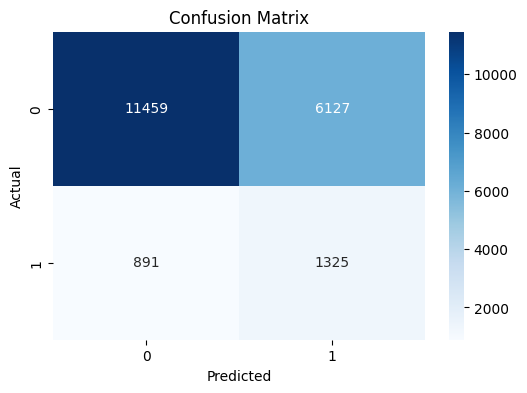

In [ ]:
# Get probabilities for Class 1 (<30 readmission)
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Basic Classification Report
print(" Classification Report (Tuned XGBoost) ")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Imbalanced Classification Metrics: PR AUC and Top K Precision

This section extended the evaluation by using metrics that are better suited for imbalanced prediction problems. The Precision Recall AUC captured how well the model ranks positive cases when events are rare, and Precision at the top ten percent measured how accurately the model identified the highest risk patients.

In [ ]:
# 1. PR-AUC (Precision-Recall Area Under Curve)
pr_auc = average_precision_score(y_test, y_prob)
print(f"PR-AUC: {pr_auc:.3f}")

# 2. Precision at Top 10%
# Measures: "Of the 10% of patients we identified as Highest Risk, how many actually came back?"
k = int(0.10 * len(y_prob))
top_k_idx = np.argsort(-y_prob)[:k]
prec_top10 = y_test.iloc[top_k_idx].mean()

print(f"Precision @ Top 10%: {prec_top10:.1%}")

PR-AUC: 0.221
Precision @ Top 10%: 25.7%


## Interpretability via SHAP(SHapley Additive exPlanations)

This section computed SHAP values to quantify how each feature contributed to the model’s predictions. The preprocessing pipeline transformed the test data, a TreeExplainer interpreted the XGBoost model, and a global SHAP summary plot highlighted the main drivers of readmission risk.

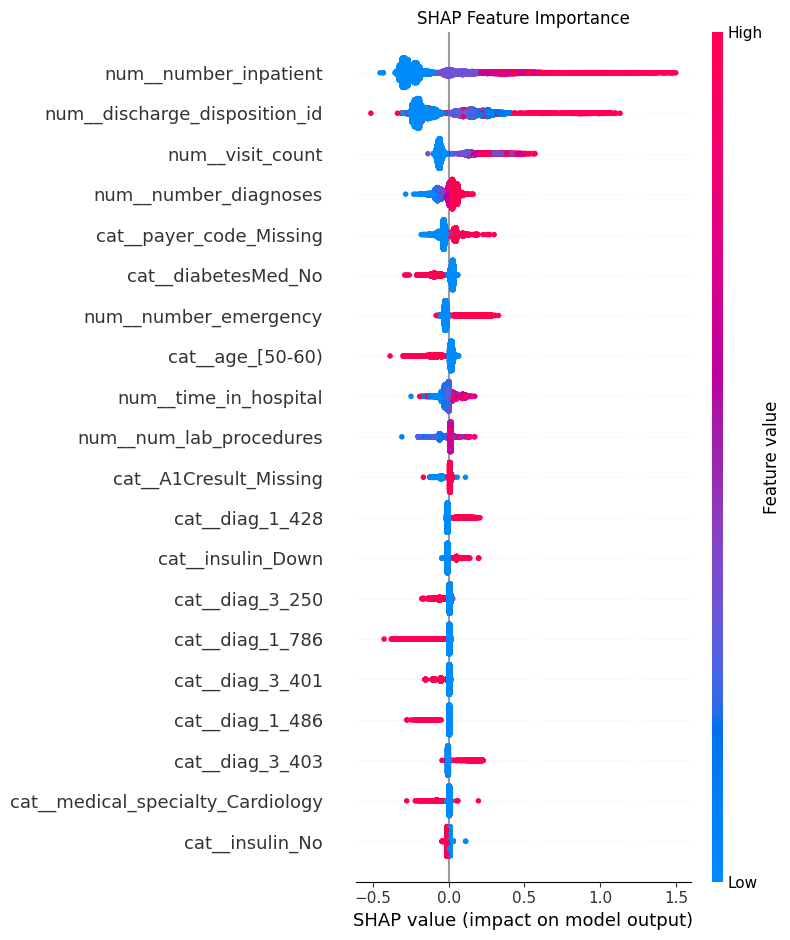

In [ ]:
# 1. Extract Steps
xgb_step = best_model.named_steps["xgb"]
prep_step = best_model.named_steps["preprocess"]

# 2. Transform Test Data
X_test_transformed = prep_step.transform(X_test)

# 3. Create Explainer
explainer = shap.TreeExplainer(xgb_step)
shap_values = explainer.shap_values(X_test_transformed)

# 4. Get Feature Names
feature_names = prep_step.get_feature_names_out()

# 5. Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

## Baseline Model Benchmarking

This phase trained Logistic Regression and Random Forest models under the same preprocessing conditions and compared them to XGBoost. Each model’s ROC AUC, PR AUC, and Precision at the top ten percent were calculated to assess relative performance.

In [ ]:
# Define Baselines
log_model = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000))
])

rf_model = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1))
])

# List of models to compare
models_to_test = [
    ("Logistic Regression", log_model),
    ("Random Forest", rf_model),
    ("Tuned XGBoost", best_model)
]

results = []

print("Running Comparison...")

for name, model in models_to_test:
    # Train baselines (XGBoost is already trained, fitting again is fast enough)
    model.fit(X_train, y_train)

    # Predict
    y_p = model.predict_proba(X_test)[:, 1]

    # Calc Metrics
    auc = roc_auc_score(y_test, y_p)
    pr = average_precision_score(y_test, y_p)

    k = int(0.10 * len(y_p))
    top_k_idx = np.argsort(-y_p)[:k]
    prec_k = y_test.iloc[top_k_idx].mean()

    results.append({
        "Model": name,
        "ROC-AUC": auc,
        "PR-AUC": pr,
        "Prec@Top10%": prec_k
    })

# Display Table
leaderboard = pd.DataFrame(results).set_index("Model")
print("\n FINAL MODEL LEADERBOARD ")
display(leaderboard.sort_values(by="ROC-AUC", ascending=False))

Running Comparison...

 FINAL MODEL LEADERBOARD 


,ROC-AUC,PR-AUC,Prec@Top10%
Model,,,
Tuned XGBoost,0.670364,0.220951,0.256566
Random Forest,0.650818,0.186674,0.222727
Logistic Regression,0.644189,0.199226,0.242929


## Robustness Check: Adding Comorbidity Features

This section added clinically relevant ICD 9 based comorbidity indicators and re evaluated model performance. Binary flags for conditions such as diabetes, heart failure, COPD, renal failure, and cancer, along with an overall comorbidity count, were engineered and incorporated into an updated pipeline. Using the same hyperparameters allowed a fair comparison of AUC before and after augmentation to assess model stability and sensitivity to these added features.

In [ ]:
# 1. Define Comorbidity Logic
print("Running Robustness Check: Adding Comorbidity Features...")

# Create a copy of the original dataframe to add features
df_robust = df.copy()

# Helper function for ICD-9 codes
diag_cols = ["diag_1", "diag_2", "diag_3"]
for c in diag_cols: df_robust[c] = df_robust[c].astype(str)

def has_prefix(row, prefixes):
    for c in diag_cols:
        if row[c] != 'nan' and any(row[c].startswith(p) for p in prefixes):
            return 1
    return 0

# Add Flags
df_robust["comorb_diabetes"] = df_robust.apply(lambda r: has_prefix(r, ["249", "250"]), axis=1)
df_robust["comorb_chf"] = df_robust.apply(lambda r: has_prefix(r, ["428"]), axis=1)
df_robust["comorb_copd"] = df_robust.apply(lambda r: has_prefix(r, ["490", "491", "492", "493", "496"]), axis=1)
df_robust["comorb_renal"] = df_robust.apply(lambda r: has_prefix(r, ["585", "586"]), axis=1)
df_robust["comorb_cancer"] = df_robust.apply(lambda r: has_prefix(r, [str(i) for i in range(140, 240)]), axis=1)
df_robust["comorb_count"] = df_robust[["comorb_diabetes", "comorb_chf", "comorb_copd", "comorb_renal", "comorb_cancer"]].sum(axis=1)

# 2. Re-Split Data with New Features
X_rob = df_robust.drop(columns=cols_to_drop + ['comorb_diabetes', 'comorb_chf', 'comorb_copd', 'comorb_renal', 'comorb_cancer', 'comorb_count']) # Temporarily drop to get clean split index
# Actually, easier way: just select rows by index
X_train_rob = df_robust.iloc[train_idx].drop(columns=cols_to_drop)
X_test_rob = df_robust.iloc[test_idx].drop(columns=cols_to_drop)
y_train_rob = y.iloc[train_idx]
y_test_rob = y.iloc[test_idx]

# Update Numerical Features list to include new columns
new_num_features = num_features + ["comorb_diabetes", "comorb_chf", "comorb_copd", "comorb_renal", "comorb_cancer", "comorb_count"]

# Update Preprocessor
rob_preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, new_num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# 3. Re-Train XGBoost (Using Best Params from Cell 6)
# We use the exact same params to make it a fair "apple-to-apple" comparison
best_params = grid_search.best_params_
# Clean up param names (remove 'xgb__' prefix)
final_params = {k.replace('xgb__', ''): v for k, v in best_params.items()}

rob_model = Pipeline([
    ("preprocess", rob_preprocess),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        scale_pos_weight=ratio,
        n_jobs=-1,
        random_state=42,
        eval_metric="auc",
        **final_params
    ))
])

rob_model.fit(X_train_rob, y_train_rob)
y_prob_rob = rob_model.predict_proba(X_test_rob)[:, 1]

# Compare
auc_orig = roc_auc_score(y_test, y_prob)
auc_rob = roc_auc_score(y_test_rob, y_prob_rob)

print(f"Original AUC: {auc_orig:.4f}")
print(f"Robustness AUC (w/ Comorbidities): {auc_rob:.4f}")
if auc_rob > auc_orig:
    print(" Result: Comorbidities improved the model!")
else:
    print(" Result: Comorbidities didn't improve AUC, but added interpretability.")

Running Robustness Check: Adding Comorbidity Features...
Original AUC: 0.6704
Robustness AUC (w/ Comorbidities): 0.6691
 Result: Comorbidities didn't improve AUC, but added interpretability.


## Optimizing for Recall (Threshold Tuning)

This section used the precision recall curve to see how different probability thresholds changed sensitivity and precision. By scanning through the full range of thresholds, we identified operating points that reached specific recall levels, such as seventy five percent.

In [ ]:
from sklearn.metrics import precision_recall_curve

# Use the robust probabilities if they were better, else use original
final_y_prob = y_prob_rob if auc_rob > auc_orig else y_prob
final_y_test = y_test_rob if auc_rob > auc_orig else y_test

precisions, recalls, thresholds = precision_recall_curve(final_y_test, final_y_prob)

# Build a tradeoff table
thr_table = pd.DataFrame({
    "threshold": np.append(thresholds, 1.0),
    "precision": precisions,
    "recall": recalls
})

print(" Threshold Trade-off Table ")
# Show thresholds where we catch at least 70% or 80% of readmissions
display(thr_table.iloc[::500].head(10)) # Sample rows to avoid printing thousands

# Example: What if we want 75% Recall?
target_recall = 0.75
optimal_row = thr_table.iloc[(thr_table['recall'] - target_recall).abs().argsort()[:1]]
opt_thresh = optimal_row['threshold'].values[0]

print(f"\nTo achieve ~75% Recall, we need Threshold = {opt_thresh:.3f}")
print(f"At this level, Precision is {optimal_row['precision'].values[0]:.3f}")

 Threshold Trade-off Table 


,threshold,precision,recall
0,0.099733,0.111908,1.000000
500,0.244628,0.114003,0.992329
1000,0.271141,0.116306,0.985560
1500,0.288623,0.118321,0.974278
2000,0.302650,0.120190,0.959838
2500,0.314723,0.122434,0.947202
3000,0.324598,0.125015,0.935469
3500,0.334166,0.128043,0.923285
4000,0.344176,0.130305,0.903430
4500,0.354726,0.133107,0.885379



To achieve ~75% Recall, we need Threshold = 0.437
At this level, Precision is 0.154


## The Policy Table (Top-K Analysis)

This section created a policy table that measured intervention outcomes under different hospital resource limits. By ranking patients by predicted risk and examining the top five to thirty percent, the analysis calculated precision and readmission coverage for each intervention tier.

In [ ]:
def get_top_k_metrics(y_true, y_score, k_fraction):
    n = int(len(y_score) * k_fraction)
    top_idx = np.argsort(-y_score)[:n]

    # Precision: What % of these top K are actually readmitted?
    prec = y_true.iloc[top_idx].mean()

    # Recall: What % of ALL readmissions did we catch in this top K?
    total_positives = y_true.sum()
    captured_positives = y_true.iloc[top_idx].sum()
    rec = captured_positives / total_positives

    return prec, rec

results_policy = []
for k in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
    p, r = get_top_k_metrics(final_y_test, final_y_prob, k)
    results_policy.append({
        "Flag Top %": f"{int(k*100)}%",
        "Precision": p,
        "Recall (Coverage)": r
    })

policy_df = pd.DataFrame(results_policy)
print(" HOSPITAL POLICY OPTIONS ")
display(policy_df)

# Narrative conclusion
best_k = policy_df.iloc[3] # 20%
print(f"\nConclusion: If the hospital has resources to intervene with the Top {best_k['Flag Top %']} of risk scores,")
print(f"they can identify {best_k['Recall (Coverage)']:.1%} of all readmissions (Precision: {best_k['Precision']:.1%}).")

 HOSPITAL POLICY OPTIONS 


,Flag Top %,Precision,Recall (Coverage)
0,5%,0.319192,0.142599
1,10%,0.256566,0.229242
2,15%,0.230976,0.309567
3,20%,0.213636,0.381769
4,25%,0.202020,0.451264
5,30%,0.189394,0.507671



Conclusion: If the hospital has resources to intervene with the Top 20% of risk scores,
they can identify 38.2% of all readmissions (Precision: 21.4%).


## Interactive Model Deployment through a Gradio Interface

This phase turned the trained XGBoost model into a user application suitable for clinical or instructional use. An interactive Gradio interface was built to allow real time risk prediction based on manually entered patient information. This gave practitioners, researchers, and students a way to explore how the model behaved and to evaluate readmission risk under different hypothetical scenarios.

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np

# 1. Setup Defaults
# This automatically grabs ALL 40+ columns (including new comorbidities)
# so the model never complains about missing data.
default_values = X_train.mode().iloc[0].to_dict()
median_values = X_train.median(numeric_only=True).to_dict()
default_values.update(median_values)

# 2. Define User-Friendly Dropdowns
diag_options = [
    "Heart Failure (428)",
    "Heart Disease / CAD (414)",
    "Chest Pain / Respiratory (786)",
    "Heart Attack (410)",
    "Pneumonia (486)",
    "Diabetes (250)",
    "Other/General (780)"
]

discharge_options = [
    "Home (1)",
    "Skilled Nursing Facility (3)",
    "Home Health Service (6)",
    "Rehab Facility (22)",
    "Transferred to Hospital (18)"
]

def predict_readmission(age, time_in_hospital, num_procedures, num_medications,
                        number_inpatient, visit_count, diag_selection, discharge_selection):

    # 1. Extract the CODE from the descriptive string
    # Example: "Heart Failure (428)" -> "428"
    diag_code = diag_selection.split('(')[-1].replace(')', '')
    discharge_code = discharge_selection.split('(')[-1].replace(')', '')

    # 2. Build DataFrame using Defaults
    input_df = pd.DataFrame([default_values])

    # 3. Overwrite with User Inputs
    input_df['age'] = age
    input_df['time_in_hospital'] = int(time_in_hospital)
    input_df['num_procedures'] = int(num_procedures)
    input_df['num_medications'] = int(num_medications)
    input_df['number_inpatient'] = int(number_inpatient)
    input_df['visit_count'] = int(visit_count)
    input_df['diag_1'] = str(diag_code)
    input_df['discharge_disposition_id'] = str(discharge_code)

    # 4. Ensure Data Types Match Training
    for col in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']:
        input_df[col] = input_df[col].astype(str)

    # 5. Predict
    prob = best_model.predict_proba(input_df)[0][1]

    return f"Readmission Risk: {prob:.1%}"

# 3. Launch App
iface = gr.Interface(
    fn=predict_readmission,
    inputs=[
        gr.Dropdown(['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'], label="Age Group", value='[70-80)'),
        gr.Slider(1, 14, step=1, label="Time in Hospital (Days)", value=3),
        gr.Slider(0, 6, step=1, label="Number of Procedures", value=0),
        gr.Slider(1, 80, step=1, label="Number of Medications", value=12),
        gr.Number(label="Inpatient Visits (Prior Year)", value=0),
        gr.Number(label="Total Visit Count (History)", value=1),

        # New Dropdowns
        gr.Dropdown(diag_options, label="Primary Diagnosis", value="Heart Failure (428)"),
        gr.Dropdown(discharge_options, label="Discharge Destination", value="Home (1)")
    ],
    outputs="text",
    title="Hospital Readmission Predictor",
    description="Predicts the probability of readmission within 30 days based on patient history and discharge details."
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6235b588b5eefd4662.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
